In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from PIL import Image

In [4]:
TRAIN_DIR = "../locrun/train"

In [42]:
# List the subdirectories (which represent class labels)
class_labels = sorted(os.listdir(TRAIN_DIR))

# Print the class labels
print("Class labels:", class_labels)

Class labels: ['B3', 'Kaca', 'Kertas', 'Metal', 'Organik', 'Plastik', 'Residu']


In [5]:
def getSubfolders(base_dir = './'):
  """
    Getting all the subdirectory names from the base directory

    Args:
        base_dir (str): The path to the base directory.
    """
  arr = next(os.walk(base_dir))[1]
  return arr

In [6]:
enum = getSubfolders(TRAIN_DIR)
print(enum)

['B3', 'Kaca', 'Kertas', 'Metal', 'Organik', 'Plastik', 'Residu']


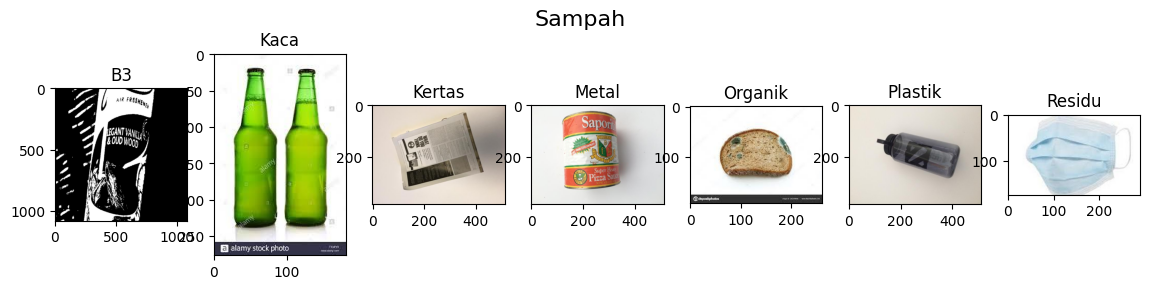

In [7]:
with tf.device("CPU"):
    fig, axes = plt.subplots(1, 7, figsize=(14, 3))
    fig.suptitle('Sampah', fontsize=16)
    
    for i, letter in enumerate(enum):
        dir = f'{TRAIN_DIR}/{letter}'
        img = tf.keras.preprocessing.image.load_img(dir+'/'+os.listdir(dir)[0])
        axes[i].imshow(img)
        axes[i].set_title(f'{letter}')

In [17]:
BATCH_SIZE = 16
W = 512
H = 512

In [18]:
def train_val_datasets():
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TRAIN_DIR,
        batch_size=BATCH_SIZE,
        image_size=(W, H),  
        label_mode="categorical",
        validation_split=0.3,
        subset="training",
        seed=43
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=TRAIN_DIR,
        batch_size=BATCH_SIZE,
        image_size=(W, H),
        label_mode="categorical",
        validation_split=0.3,
        subset="validation",
        seed=43
    )
    return train_dataset, validation_dataset

In [19]:
with tf.device("CPU"):
    train_dataset, validation_dataset = train_val_datasets()
    print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
    print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
    print(f"Images of validation dataset have shape: {validation_dataset.element_spec[0].shape}")
    print(f"Labels of validation dataset have shape: {validation_dataset.element_spec[1].shape}")

Found 63000 files belonging to 7 classes.
Using 44100 files for training.
Found 63000 files belonging to 7 classes.
Using 18900 files for validation.
Images of train dataset have shape: (None, 512, 512, 3)
Labels of train dataset have shape: (None, 7)
Images of validation dataset have shape: (None, 512, 512, 3)
Labels of validation dataset have shape: (None, 7)


In [20]:
# Updated model with adjustments for regularization
def create_model():
    model = tf.keras.models.Sequential([
        # Input layer and normalization
        tf.keras.Input(shape=(W, H, 3)),
        tf.keras.layers.Rescaling(1./255),

        # First convolutional block
        tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),  # Sedikit mengurangi dropout

        # Second convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),

        # Third convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),

        # Fully connected layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(7, activation='softmax')  # Output layer
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Learning rate diturunkan
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [21]:
with tf.device("CPU"):
    modelnew = create_model()

In [23]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, monitor_loss, monitor_accuracy, loss_threshold, accuracy_threshold, patience=5):
        super(CustomEarlyStopping, self).__init__()
        self.monitor_loss = monitor_loss
        self.monitor_accuracy = monitor_accuracy
        self.loss_threshold = loss_threshold
        self.accuracy_threshold = accuracy_threshold
        self.patience = patience
        self.best_epoch = 0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get(self.monitor_loss)
        val_accuracy = logs.get(self.monitor_accuracy)

        if val_loss is not None and val_accuracy is not None:
            if val_loss <= self.loss_threshold and val_accuracy >= self.accuracy_threshold:
                print(f"\nStopping training as both criteria met at epoch {epoch + 1}:")
                print(f"val_loss <= {self.loss_threshold} and val_accuracy >= {self.accuracy_threshold}")
                self.modelnew.stop_training = True
            else:
                if epoch > self.best_epoch:
                    self.best_epoch = epoch
                    self.wait = 0
                else:
                    self.wait += 1
                    if self.wait >= self.patience:
                        print("\nStopping training due to no improvement.")
                        self.model.stop_training = True

# Define early stopping parameters
custom_early_stopping = CustomEarlyStopping(
    monitor_loss='val_loss',
    monitor_accuracy='val_accuracy',
    loss_threshold=0.2,
    accuracy_threshold=0.9,
)
with tf.device("GPU"):
    # Training the model with the custom early stopping callback
    history = modelnew.fit(
        train_dataset,
        epochs=100,
        validation_data=validation_dataset,
        callbacks=[custom_early_stopping]
    )

Epoch 1/100
2757/2757 [==============================] - 568s 205ms/step - loss: 1.4396 - accuracy: 0.5069 - val_loss: 1.3690 - val_accuracy: 0.4858
Epoch 2/100
2757/2757 [==============================] - 522s 189ms/step - loss: 1.0682 - accuracy: 0.6295 - val_loss: 0.9833 - val_accuracy: 0.6415
Epoch 3/100
2757/2757 [==============================] - 516s 187ms/step - loss: 0.9327 - accuracy: 0.6784 - val_loss: 0.8104 - val_accuracy: 0.7173
Epoch 4/100
2757/2757 [==============================] - 521s 189ms/step - loss: 0.8419 - accuracy: 0.7125 - val_loss: 0.9422 - val_accuracy: 0.6696
Epoch 5/100
2757/2757 [==============================] - 521s 189ms/step - loss: 0.7792 - accuracy: 0.7364 - val_loss: 0.8375 - val_accuracy: 0.7051
Epoch 6/100
2757/2757 [==============================] - 521s 189ms/step - loss: 0.7286 - accuracy: 0.7550 - val_loss: 1.6194 - val_accuracy: 0.5402
Epoch 7/100
2757/2757 [==============================] - 523s 190ms/step - loss: 0.6769 - accuracy: 0.7710

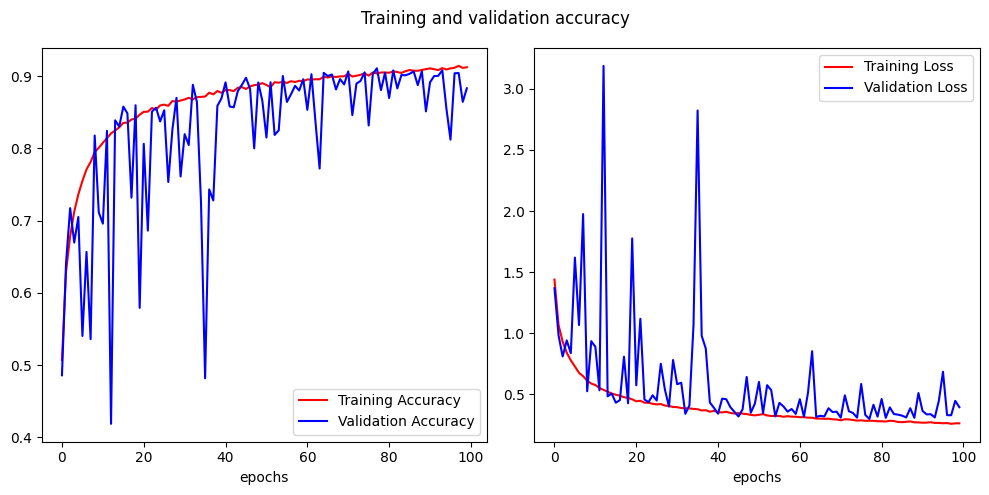

In [24]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.tight_layout()
plt.show()

In [25]:
export_dir = 'bestoneyet.h5'
modelnew.save(export_dir)

In [26]:
new_model = tf.keras.models.load_model('bestoneyet.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 512, 512, 16)      448       
                                                                 
 batch_normalization_4 (Batc  (None, 512, 512, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 batch_normalization_5 (Batc  (None, 256, 256, 16)    

In [28]:
finished_model = tf.keras.models.load_model('bestoneyet.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(finished_model)
tflite_model = converter.convert()
open("bestoneyet.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\DAVID'~1\AppData\Local\Temp\tmp9yaei3ot\assets


INFO:tensorflow:Assets written to: C:\Users\DAVID'~1\AppData\Local\Temp\tmp9yaei3ot\assets


1351208